In [1]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds
import ipywidgets as widgets
from IPython.display import display, clear_output


In [56]:
def reset(T1):
    Mz = np.ones(len(T1))
    return Mz
def invert(Mz,eff=1.0):
    Mz = Mz * -eff
    return Mz

def relax(Mz,T1,t):
    Mz = 1 - (1-Mz) * np.exp(-t/T1)
    return Mz

def read(Mz,FA,N,T1,TR1):
    for i in range(N):
        sig = np.sin(FA / 180 * np.pi) * Mz
        Mz = Mz * np.cos(FA / 180 * np.pi);
        Mz = relax(Mz,T1,TR1)
    return Mz,sig


In [151]:
def singleTR(Mz,param):
    try:
        invEff = param['invEff']
    except:
        invEff = 1.0
    # calculate helper times
    readDur = param['N'] * param['TR1']
    TI1fill = param['TI1'] - readDur/2
    TI2fill = param['TI2'] - param['TI1'] - readDur
    TRfill = param['TR0'] - 2*readDur - TI1fill - TI2fill
    if TI1fill < 0:
        raise ValueError("TI1 too short!")
    if TI2fill < 0:
        raise ValueError("TI2 too short!")
    if TRfill < 0:
        raise ValueError("TR too short!")
    N1 = int(param['N']/2)
    N2 = param['N'] - N1
    #plt.plot(param['T1'],Mz,label="fresh")
    Mz = invert(Mz)
    #plt.plot(param['T1'],Mz,label="invert")
    Mz = relax(Mz,param['T1'],TI1fill)
    # plt.plot(param['T1'],Mz,label="before sig1")
    Mz,sig1 = read(Mz,FA=param['FA1'],N=N1,T1=param['T1'],TR1=param['TR1'])
    Mz = read(Mz,FA=param['FA1'],N=N2,T1=param['T1'],TR1=param['TR1'])[0]
    # plt.plot(param['T1'],Mz,label="after sig1")
    Mz = relax(Mz,param['T1'],TI2fill)
    # plt.plot(param['T1'],Mz,label="before sig2")
    Mz,sig2 = read(Mz,FA=param['FA2'],N=N1,T1=param['T1'],TR1=param['TR1'])
    Mz = read(Mz,FA=param['FA2'],N=N2,T1=param['T1'],TR1=param['TR1'])[0]
    # plt.plot(param['T1'],Mz,label="after sig2")
    Mz = relax(Mz,param['T1'],TRfill)
    # plt.plot(param['T1'],Mz,label="end TR")
    # plt.legend()
    # plt.show()
    return Mz,sig1,sig2

# run enough times to approximate steady state
def runParameters(param):
    Mz = reset(param['T1'])
    niter=7
    for i in range(niter):
        Mz,sig1,sig2 = singleTR(Mz,param)
    return sig1,sig2,Mz


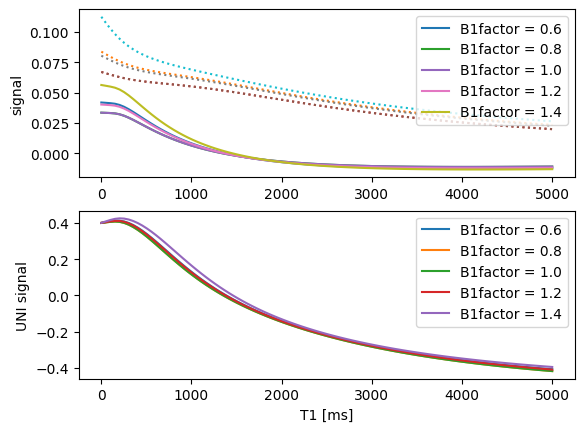

In [160]:
param = dict()
param['TI1'] = 900
param['TI2'] = 4500
param['FA1'] = 4
param['FA2'] = 8
param['TR0'] = 8000
param['TR1'] = 6.5
param['T1'] = np.linspace(1,5000,100)
param['N'] = 224

B1fac = [0.6,0.8,1.0,1.2,1.4]

plt.figure()
for b1 in B1fac:
    myParam = param
    myParam['FA1'] = param['FA1'] * b1
    myParam['FA2'] = param['FA2'] * b1
    sig1,sig2,Mz = runParameters(myParam)
    plt.subplot(2,1,1)
    plt.plot(param['T1'],sig1,label=f'B1factor = {b1}')
    plt.plot(param['T1'],sig2,':')
    uni = (sig1 * sig2) / (abs(sig1)**2 + abs(sig2)**2)
    plt.subplot(2,1,2)
    plt.plot(param['T1'],uni,label=f'B1factor = {b1}')
plt.subplot(2,1,1)
plt.ylabel("signal")
plt.legend()

plt.subplot(2,1,2)
plt.xlabel("T1 [ms]")
plt.ylabel("UNI signal")
plt.legend()
plt.show()

In [ ]:
invEff = [1.0,0.95,0.9,0.85,0.8]
plt.figure()
for eff in invEff:
    myParam = param
    param['invEff'] = eff
    sig1,sig2,Mz = runParameters(myParam)
    plt.subplot(2,1,1)
    plt.plot(param['T1'],sig1,label=f'B1factor = {b1}')
    plt.plot(param['T1'],sig2,':')
    uni = (sig1 * sig2) / (abs(sig1)**2 + abs(sig2)**2)
    plt.subplot(2,1,2)
    plt.plot(param['T1'],uni,label=f'B1factor = {b1}')
plt.subplot(2,1,1)
plt.ylabel("signal")
plt.legend()

plt.subplot(2,1,2)
plt.xlabel("T1 [ms]")
plt.ylabel("UNI signal")
plt.legend()
plt.show()

In [ ]:
def plotFAdependence(param):
    param2 = param.copy()
    FAs = np.linspace(param['FA']-2,param['FA']+2,30)

    cont = np.zeros(len(FAs))
    sG   = np.zeros(len(FAs))
    sW   = np.zeros(len(FAs))
    for i,f in enumerate(FAs):
        param2['FA'] = f
        sig = runParameters(param2)
        cont[i] = sig[1]/sig[0]
        sG[i] = sig[0]
        sW[i] = sig[1]

    fig, ax1 = plt.subplots()
    ax1.plot(FAs,cont,color='C0')
    ax1.set_title(f'FA variation (FA={param["FA"]:.1f} deg)')
    ax1.set_ylabel('WM/GM contrast', color='C0')
    ax1.vlines(param['FA'],ymin=min(cont),ymax=max(cont),color='gray')
    ax1.set_xlabel('FA [deg]')
    ax2 = ax1.twinx()
    ax2.plot(FAs,sG,color='C1')
    ax2.plot(FAs,sW,color='C2')
    plt.grid()
    ax2.set_ylabel('GM signal', color='C1')
    ax2.legend(['GM','WM'],loc='right')
    plt.show()
def plotTIdependence(param):
    param2 = param.copy()
    TIs = np.linspace(param["TI"]-200,param["TI"]+200,30)

    cont = np.zeros(len(TIs))
    sG   = np.zeros(len(TIs))
    sW   = np.zeros(len(TIs))
    for i,t in enumerate(TIs):
        param2['TI'] = t
        sig = runParameters(param2)
        cont[i] = sig[1]/sig[0]
        sG[i] = sig[0]
        sW[i] = sig[1]

    fig, ax1 = plt.subplots()
    ax1.plot(TIs,cont,color='C0')
    ax1.set_title(f'TI variation (TI={param["TI"]:.0f} ms)')
    ax1.set_ylabel('WM/GM contrast', color='C0')
    ax1.vlines(x=param["TI"],ymin=min(cont),ymax=max(cont),color='gray')
    ax2 = ax1.twinx()
    ax2.plot(TIs,sG,color='C1')
    ax2.plot(TIs,sW,color='C2')
    plt.grid()
    ax1.set_xlabel('TI [ms]')
    ax2.set_ylabel('GM signal', color='C1')
    ax2.legend(['GM','WM'],loc='right')
    plt.show()

In [ ]:

def optimize_values(param,target_cont,target_sig):
    def cost(x,verbose=False):
        param['FA'] = x[0]
        param['TI'] = x[1]
        sig = runParameters(param)
        cont = sig[1]/sig[0]
        cost_cont = abs(cont-target_cont)**2
        cost_sig = abs(sig[0]-target_sig)**2 * 1e1
        cost_sig2 = abs(1/sig[0])* 1e-3

        cost_total = cost_cont + cost_sig

        if verbose:
            print(f'cont:    {cont:6.3f}')
            print(f'GM-sig:  {sig[0]*100:6.3f}')
        return cost_total
    
    x0 = [param['FA'],param['TI']]
    lb = [1,np.ceil(param['TR1']*param['N']/2)]
    ub = [90,param['TR0']-np.ceil(param['TR1']*param['N']/2)]
    bounds = Bounds(lb,ub)
    
    x1 = minimize(cost,x0,method='L-BFGS-B',bounds=bounds)
    
    with output:
        clear_output()
        print(f'Duration: {param["N_part"]*param["TR0"]/1000/60:.2f} min')
        # print('\nOld:')
        # print(f'FA:    {x0[0]:7.2f} deg')
        # print(f'TI:    {x0[1]:7.2f} ms')
        # cost(x0,verbose=True)
        print('\nNew:')
        print(f'FA:    {x1.x[0]:7.2f} deg')
        print(f'TI:    {x1.x[1]:7.2f} ms')
        cost(x1.x,verbose=True)
        if check_FAplot.value:
            plotFAdependence(param)
        if check_TIplot.value:
            plotTIdependence(param)


In [ ]:
TR_slider = widgets.IntSlider(
    value=3360,
    min=1000,
    max=10000,
    step=10,
    description='Segment-TR:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
TR1_slider = widgets.FloatSlider(
    value=6.1,
    min=1,
    max=20,
    step=0.1,
    description='Readout-TR:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f'
)
N_slider = widgets.IntSlider(
    value=132,
    min=20,
    max=500,
    step=1,
    description='Seg Length:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
Npart_slider = widgets.IntSlider(
    value=120,
    min=10,
    max=500,
    step=1,
    description='N_segments:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
Cont_slider = widgets.FloatSlider(
    value=1.7,
    min=1.0,
    max=3.0,
    step=0.1,
    description='contrast:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f'
)
sig_slider = widgets.FloatSlider(
    value=4.0,
    min=0.0,
    max=4.0,
    step=0.1,
    description='Signal target:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f'
)
output = widgets.Output()
def update_values(change):
    param = dict()
    param['T1'] = np.asarray([2002,1425])
    param['N'] = 132
    param['TR1'] = 6.06
    param['TR0'] = 3360
    param['FA'] = 9.0
    param['TI'] = 1340
    param['N_part'] = Npart_slider.value
    
    param['TR0'] = TR_slider.value
    param['TR1'] = TR1_slider.value
    param['N'] = N_slider.value
    target_cont = Cont_slider.value
    target_sig = sig_slider.value/100
    optimize_values(param,target_cont,target_sig)

# MPRAGE parameter optimization tool

Assuming T1=2002 for GM and T1=1425 for WM

Set sequence parameters (TR,segment length, etc) first.
Then select target WM/GM contrast.

The displayed signal is `sin(alpha) * Mz * 100`, so a 90° pulse after full relaxation would result in signal 100. This is a slightly arbitrary value and only gives an idea about the performance.




In [ ]:
sig_slider.observe(update_values, 'value')
TR_slider.observe(update_values, 'value')
N_slider.observe(update_values, 'value')
Cont_slider.observe(update_values, 'value')
Npart_slider.observe(update_values,'value')
TR1_slider.observe(update_values,'value')

check_FAplot.observe(update_values,'value')
check_TIplot.observe(update_values,'value')

display(TR_slider)
display(TR1_slider)
display(N_slider)
display(Npart_slider)
display(Cont_slider)
display(check_FAplot)
display(check_TIplot)
#display(sig_slider)
display(output)
update_values(0)

IntSlider(value=3360, continuous_update=False, description='Segment-TR:', max=8000, min=1000, step=10)

FloatSlider(value=6.1, continuous_update=False, description='Readout-TR:', max=20.0, min=1.0, readout_format='…

IntSlider(value=132, continuous_update=False, description='Seg Length:', max=500, min=20)

IntSlider(value=120, continuous_update=False, description='N_segments:', max=500, min=10)

FloatSlider(value=1.7, continuous_update=False, description='contrast:', max=3.0, min=1.0, readout_format='.1f…

Output()

```
Old:
FA:       9.00 deg
TI:    1340.00 ms
cont:     1.692
GM-sig:   1.909
```

In [ ]:
param = dict()
param['T1'] = np.asarray([2002,1425]) # GM,WM
param['N'] = 132
param['N_part'] = 120
param['TR1'] = 6.06
param['TR0'] = 3360
param['FA'] = 9.0
param['TI'] = 1340
target_cont = 2.0
target_sig = 0.01
optimize_values(param,target_cont,target_sig)